In [1]:
#importing libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pickle
import json
from Utils.evaluation import EvaluationMetrics, ActualStats
from Utils.helper import *
from Utils.sample_squads import *

## Innings 1

In [2]:
model_inn1 = tf.keras.models.load_model('Models\Inn1-HeavyDense-ep20to50\cp-0029.h5')
model_inn2 = tf.keras.models.load_model('Models\Inn2-HeavyDenseRequired-ep30to50\cp-0016.h5')

In [3]:
evaluator = EvaluationMetrics(model_inn1, model_inn2,
                              # )
                              "Evaluation/tournament2.pkl")

In [5]:
evaluator.reinitialize_tournament()
for _ in range(56):
    print(f"\n\nMatch number: {evaluator.match_count+1}")
    evaluator.simulate_match(1)
evaluator.display_table()
evaluator.save_object("Evaluation/tournament2.pkl")



Match number: 1
Kings XI Punjab  :  160 / 10  in  17 . 2
Extras: 9



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,KL Rahul,0,0,0,1,Caught,JD Unadkat
1,CH Gayle,34,5,1,21,Bowled,S Gopal
2,MA Agarwal,83,5,7,43,Caught,R Parag
3,DA Miller,3,0,0,5,Caught,S Gopal
4,N Pooran,1,0,0,1,Run Out,-
5,Mandeep Singh,11,0,0,10,Caught,J Archer
6,R Ashwin,0,0,0,1,Caught,R Parag
7,H Viljoen,7,1,0,8,Caught,J Archer
8,M Ashwin,12,0,1,10,Stumped,DS Kulkarni
9,Mohammed Shami,0,0,0,3,Caught,DS Kulkarni



Rajasthan Royals  :  160 / 7  in  20 . 0
Extras: 6



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,AM Rahane,37,3,1,31,Caught,R Ashwin
1,JC Buttler,17,3,0,13,Caught,Mohammed Shami
2,SV Samson,6,1,0,8,LBW,H Viljoen
3,SPD Smith,11,2,0,6,Bowled,H Viljoen
4,RA Tripathi,12,1,0,15,Caught,R Ashwin
5,BA Stokes,1,0,0,2,Caught,R Ashwin
6,R Parag,24,2,1,16,Caught,AS Rajpoot
7,J Archer,40,4,2,23,Not Out,-
8,S Gopal,6,0,0,7,Not Out,-
9,DS Kulkarni,-,-,-,-,-,-



Both teams have hit 160 and the game has ended in a tie


Match number: 2
Kolkata Knight Riders  :  180 / 3  in  20 . 0
Extras: 13



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,S Gill,16,1,0,18,Run Out,-
1,CA Lynn,79,5,3,54,Not Out,-
2,RV Uthappa,30,3,1,21,Caught,YS Chahal
3,N Rana,41,3,2,27,Stumped,UT Yadav
4,AD Russell,1,0,0,1,Not Out,-
5,KD Karthik,-,-,-,-,-,-
6,SP Narine,-,-,-,-,-,-
7,PP Chawla,-,-,-,-,-,-
8,Kuldeep Yadav,-,-,-,-,-,-
9,L Ferguson,-,-,-,-,-,-



Royal Challengers Bangalore  :  181 / 5  in  18 . 1
Extras: 19



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,PA Patel,45,4,2,30,Caught,PP Chawla
1,V Kohli,24,3,0,16,Caught,SP Narine
2,AB de Villiers,21,1,1,19,Bowled,PP Chawla
3,M Ali,4,0,0,4,Caught,Kuldeep Yadav
4,S Hetmyer,47,6,1,26,Caught,Prasidh Krishna
5,S Dube,20,1,1,13,Not Out,-
6,C de Grandhomme,1,0,0,1,Not Out,-
7,N Saini,-,-,-,-,-,-
8,YS Chahal,-,-,-,-,-,-
9,UT Yadav,-,-,-,-,-,-



Royal Challengers Bangalore won by 5 Wickets


Match number: 3
Kings XI Punjab  :  123 / 9  in  20 . 0
Extras: 12



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,KL Rahul,1,0,0,5,Caught,L Ferguson
1,CH Gayle,7,0,1,5,LBW,L Ferguson
2,MA Agarwal,21,4,0,13,Caught,SP Narine
3,DA Miller,11,0,0,18,Bowled,Kuldeep Yadav
4,N Pooran,8,0,1,5,Caught,SP Narine
5,Mandeep Singh,7,0,1,6,Bowled,PP Chawla
6,R Ashwin,29,3,0,28,Not Out,-
7,H Viljoen,0,0,0,6,Caught,Kuldeep Yadav
8,M Ashwin,17,1,0,24,Bowled,Prasidh Krishna
9,Mohammed Shami,0,0,0,1,Caught,Prasidh Krishna



Kolkata Knight Riders  :  124 / 3  in  17 . 3
Extras: 4



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,S Gill,53,5,0,46,Not Out,-
1,CA Lynn,6,1,0,5,Caught,Mohammed Shami
2,RV Uthappa,35,2,1,37,Caught,R Ashwin
3,N Rana,13,0,1,9,Caught,M Ashwin
4,AD Russell,13,1,1,8,Not Out,-
5,KD Karthik,-,-,-,-,-,-
6,SP Narine,-,-,-,-,-,-
7,PP Chawla,-,-,-,-,-,-
8,Kuldeep Yadav,-,-,-,-,-,-
9,L Ferguson,-,-,-,-,-,-



Kolkata Knight Riders won by 7 Wickets


Match number: 4
Rajasthan Royals  :  137 / 8  in  20 . 0
Extras: 9



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,AM Rahane,0,0,0,2,Caught,DL Chahar
1,JC Buttler,58,5,2,49,Bowled,DJ Bravo
2,SV Samson,0,0,0,2,Caught,DL Chahar
3,SPD Smith,1,0,0,4,Caught,DL Chahar
4,RA Tripathi,7,1,0,10,Caught,SN Thakur
5,BA Stokes,23,0,1,23,Caught,Imran Tahir
6,R Parag,12,1,0,13,Bowled,DJ Bravo
7,J Archer,21,2,1,12,Run Out,-
8,S Gopal,0,0,0,1,Not Out,-
9,DS Kulkarni,6,1,0,4,Not Out,-



Chennai Super Kings  :  143 / 0  in  14 . 1
Extras: 4



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,50,4,3,35,Not Out,-
1,F du Plessis,89,10,3,51,Not Out,-
2,SK Raina,-,-,-,-,-,-
3,AT Rayudu,-,-,-,-,-,-
4,KM Jadhav,-,-,-,-,-,-
5,MS Dhoni,-,-,-,-,-,-
6,RA Jadeja,-,-,-,-,-,-
7,DJ Bravo,-,-,-,-,-,-
8,SN Thakur,-,-,-,-,-,-
9,DL Chahar,-,-,-,-,-,-



Chennai Super Kings won by 10 Wickets


Match number: 5
Delhi Capitals  :  189 / 1  in  20 . 0
Extras: 4



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,P Shaw,68,5,2,51,Not Out,-
1,S Dhawan,116,9,7,68,Caught,Mohammed Shami
2,SS Iyer,1,0,0,1,Not Out,-
3,RR Pant,-,-,-,-,-,-
4,CA Ingram,-,-,-,-,-,-
5,S Rutherford,-,-,-,-,-,-
6,AR Patel,-,-,-,-,-,-
7,A Mishra,-,-,-,-,-,-
8,K Rabada,-,-,-,-,-,-
9,I Sharma,-,-,-,-,-,-



Kings XI Punjab  :  192 / 3  in  19 . 3
Extras: 11



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,KL Rahul,18,2,1,13,Run Out,-
1,CH Gayle,83,8,4,49,Caught,A Mishra
2,MA Agarwal,27,4,1,20,Stumped,A Mishra
3,DA Miller,37,3,2,23,Not Out,-
4,N Pooran,16,2,0,12,Not Out,-
5,Mandeep Singh,-,-,-,-,-,-
6,R Ashwin,-,-,-,-,-,-
7,H Viljoen,-,-,-,-,-,-
8,M Ashwin,-,-,-,-,-,-
9,Mohammed Shami,-,-,-,-,-,-



Kings XI Punjab won by 7 Wickets


Match number: 6
Rajasthan Royals  :  169 / 5  in  20 . 0
Extras: 6



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,AM Rahane,69,8,2,50,Caught,SP Narine
1,JC Buttler,9,1,0,11,Caught,SP Narine
2,SV Samson,61,1,5,43,Bowled,L Ferguson
3,SPD Smith,11,2,0,9,Bowled,Prasidh Krishna
4,RA Tripathi,11,0,1,5,Not Out,-
5,BA Stokes,2,0,0,2,Run Out,-
6,R Parag,0,0,0,0,Not Out,-
7,J Archer,-,-,-,-,-,-
8,S Gopal,-,-,-,-,-,-
9,DS Kulkarni,-,-,-,-,-,-



Kolkata Knight Riders  :  165 / 2  in  20 . 0
Extras: 8



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,S Gill,19,2,0,23,Bowled,R Parag
1,CA Lynn,18,1,1,17,Bowled,R Parag
2,RV Uthappa,32,2,1,32,Not Out,-
3,N Rana,88,8,5,49,Not Out,-
4,AD Russell,-,-,-,-,-,-
5,KD Karthik,-,-,-,-,-,-
6,SP Narine,-,-,-,-,-,-
7,PP Chawla,-,-,-,-,-,-
8,Kuldeep Yadav,-,-,-,-,-,-
9,L Ferguson,-,-,-,-,-,-



Rajastan Royals won by 4 Runs


Match number: 7
Mumbai Indians  :  186 / 6  in  20 . 0
Extras: 24



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,Q de Kock,22,1,2,16,Caught,DS Kulkarni
1,RG Sharma,40,5,0,33,Caught,S Gopal
2,SA Yadav,41,7,1,22,Bowled,J Archer
3,Ishan Kishan,15,0,1,14,LBW,S Gopal
4,HH Pandya,19,3,0,15,Not Out,-
5,KA Pollard,1,0,0,3,Caught,J Archer
6,KH Pandya,17,1,1,16,Run Out,-
7,RD Chahar,7,0,1,3,Not Out,-
8,J Behrendorff,-,-,-,-,-,-
9,JJ Bumrah,-,-,-,-,-,-



Rajasthan Royals  :  176 / 5  in  20 . 0
Extras: 7



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,AM Rahane,23,3,0,22,Caught,RD Chahar
1,JC Buttler,15,2,0,11,Caught,SL Malinga
2,SV Samson,63,2,3,44,Not Out,-
3,SPD Smith,10,2,0,8,Bowled,RD Chahar
4,RA Tripathi,1,0,0,3,Run Out,-
5,BA Stokes,50,4,3,28,Caught,JJ Bumrah
6,R Parag,7,1,0,4,Not Out,-
7,J Archer,-,-,-,-,-,-
8,S Gopal,-,-,-,-,-,-
9,DS Kulkarni,-,-,-,-,-,-



Mumbai Indians won by 10 Runs


Match number: 8
Kings XI Punjab  :  153 / 6  in  20 . 0
Extras: 9



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,KL Rahul,17,0,1,17,Caught,N Saini
1,CH Gayle,10,2,0,6,Caught,UT Yadav
2,MA Agarwal,0,0,0,2,Caught,Mohammed Siraj
3,DA Miller,34,3,0,33,Caught,C de Grandhomme
4,N Pooran,66,4,5,46,Caught,Mohammed Siraj
5,Mandeep Singh,16,2,0,12,Not Out,-
6,R Ashwin,1,0,0,3,Caught,UT Yadav
7,H Viljoen,0,0,0,1,Not Out,-
8,M Ashwin,-,-,-,-,-,-
9,Mohammed Shami,-,-,-,-,-,-



Royal Challengers Bangalore  :  156 / 3  in  17 . 1
Extras: 12



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,PA Patel,20,2,0,17,Caught,H Viljoen
1,V Kohli,29,0,3,23,Caught,R Ashwin
2,AB de Villiers,14,3,0,12,Bowled,H Viljoen
3,M Ali,58,7,3,32,Not Out,-
4,S Hetmyer,23,1,1,19,Not Out,-
5,S Dube,-,-,-,-,-,-
6,C de Grandhomme,-,-,-,-,-,-
7,N Saini,-,-,-,-,-,-
8,YS Chahal,-,-,-,-,-,-
9,UT Yadav,-,-,-,-,-,-



Royal Challengers Bangalore won by 7 Wickets


Match number: 9
Delhi Capitals  :  176 / 7  in  20 . 0
Extras: 11



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,P Shaw,60,7,2,43,Caught,Rashid Khan
1,S Dhawan,15,2,0,14,Caught,Rashid Khan
2,SS Iyer,6,0,1,6,Caught,S Kaul
3,RR Pant,9,1,0,13,Caught,Mohammad Nabi
4,CA Ingram,30,0,3,18,Caught,Rashid Khan
5,S Rutherford,25,2,1,17,Not Out,-
6,AR Patel,16,2,1,7,Caught,B Kumar
7,A Mishra,1,0,0,3,LBW,Sandeep Sharma
8,K Rabada,3,0,0,2,Not Out,-
9,I Sharma,-,-,-,-,-,-



Sunrisers Hyderabad  :  152 / 8  in  20 . 0
Extras: 14



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,J Bairstow,36,1,3,24,Bowled,S Lamichhane
1,DA Warner,1,0,0,4,Caught,I Sharma
2,MK Pandey,9,1,0,15,Caught,AR Patel
3,V Shankar,5,0,0,9,Caught,A Mishra
4,YK Pathan,15,0,1,15,Caught,S Lamichhane
5,DJ Hooda,22,1,2,13,Caught,AR Patel
6,Mohammad Nabi,37,3,1,24,Not Out,-
7,B Kumar,4,1,0,2,Caught,AR Patel
8,Rashid Khan,7,0,0,10,Caught,I Sharma
9,S Kaul,2,0,0,4,Not Out,-



Delhi Capitals won by 24 Runs


Match number: 10
Delhi Capitals  :  198 / 2  in  20 . 0
Extras: 7



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,P Shaw,14,2,0,15,Stumped,JJ Bumrah
1,S Dhawan,93,9,4,55,Not Out,-
2,SS Iyer,5,0,0,6,Stumped,RD Chahar
3,RR Pant,78,7,4,45,Not Out,-
4,CA Ingram,-,-,-,-,-,-
5,S Rutherford,-,-,-,-,-,-
6,AR Patel,-,-,-,-,-,-
7,A Mishra,-,-,-,-,-,-
8,K Rabada,-,-,-,-,-,-
9,I Sharma,-,-,-,-,-,-



Mumbai Indians  :  145 / 8  in  20 . 0
Extras: 10



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,Q de Kock,27,1,2,23,Caught,A Mishra
1,RG Sharma,0,0,0,3,Bowled,K Rabada
2,SA Yadav,11,2,0,6,Caught,I Sharma
3,Ishan Kishan,63,7,2,45,Caught,A Mishra
4,HH Pandya,0,0,0,5,Bowled,S Lamichhane
5,KA Pollard,5,0,0,11,Caught,AR Patel
6,KH Pandya,2,0,0,3,Caught,AR Patel
7,RD Chahar,10,2,0,5,Caught,K Rabada
8,J Behrendorff,12,0,1,14,Not Out,-
9,JJ Bumrah,5,0,0,5,Not Out,-



Delhi Capitals won by 53 Runs


Match number: 11
Royal Challengers Bangalore  :  157 / 9  in  20 . 0
Extras: 7



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,PA Patel,53,6,1,47,Caught,AR Patel
1,V Kohli,31,3,1,23,Caught,S Lamichhane
2,AB de Villiers,8,1,0,6,Bowled,S Lamichhane
3,M Ali,26,2,2,15,Caught,AR Patel
4,S Hetmyer,2,0,0,6,Caught,AR Patel
5,S Dube,4,1,0,2,Caught,A Mishra
6,C de Grandhomme,2,0,0,2,Caught,AR Patel
7,N Saini,3,0,0,11,Not Out,-
8,YS Chahal,13,0,2,4,Caught,K Rabada
9,UT Yadav,0,0,0,0,Run Out,-



Delhi Capitals  :  158 / 4  in  18 . 1
Extras: 5



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,P Shaw,4,1,0,2,Caught,Mohammed Siraj
1,S Dhawan,4,1,0,2,Run Out,-
2,SS Iyer,68,7,2,51,Not Out,-
3,RR Pant,40,4,1,32,Caught,YS Chahal
4,CA Ingram,21,1,2,14,Caught,C de Grandhomme
5,S Rutherford,16,1,1,8,Not Out,-
6,AR Patel,-,-,-,-,-,-
7,A Mishra,-,-,-,-,-,-
8,K Rabada,-,-,-,-,-,-
9,I Sharma,-,-,-,-,-,-



Delhi Capitals won by 6 Wickets


Match number: 12
Royal Challengers Bangalore  :  162 / 6  in  20 . 0
Extras: 7



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,PA Patel,9,0,1,6,Caught,B Kumar
1,V Kohli,32,5,1,18,Caught,S Kaul
2,AB de Villiers,41,5,0,33,Caught,Rashid Khan
3,M Ali,16,3,0,14,Caught,S Kaul
4,S Hetmyer,10,1,0,14,LBW,B Kumar
5,S Dube,24,3,1,16,Bowled,B Kumar
6,C de Grandhomme,14,1,0,15,Not Out,-
7,N Saini,9,1,0,5,Not Out,-
8,YS Chahal,-,-,-,-,-,-
9,UT Yadav,-,-,-,-,-,-



Sunrisers Hyderabad  :  163 / 3  in  19 . 0
Extras: 5



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,J Bairstow,24,2,0,23,Bowled,N Saini
1,DA Warner,56,5,2,47,Caught,N Saini
2,MK Pandey,19,1,2,11,Caught,YS Chahal
3,V Shankar,28,3,1,20,Not Out,-
4,YK Pathan,31,3,2,13,Not Out,-
5,DJ Hooda,-,-,-,-,-,-
6,Mohammad Nabi,-,-,-,-,-,-
7,B Kumar,-,-,-,-,-,-
8,Rashid Khan,-,-,-,-,-,-
9,S Kaul,-,-,-,-,-,-



Sunrisers Hyderabad won by 7 Wickets


Match number: 13
Rajasthan Royals  :  193 / 5  in  20 . 0
Extras: 9



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,AM Rahane,5,1,0,6,Caught,SN Thakur
1,JC Buttler,11,0,1,8,Caught,DL Chahar
2,SV Samson,48,3,3,37,Caught,RA Jadeja
3,SPD Smith,46,3,3,29,Run Out,-
4,RA Tripathi,46,2,3,25,Not Out,-
5,BA Stokes,17,2,1,8,Caught,SN Thakur
6,R Parag,11,1,0,8,Not Out,-
7,J Archer,-,-,-,-,-,-
8,S Gopal,-,-,-,-,-,-
9,DS Kulkarni,-,-,-,-,-,-



Chennai Super Kings  :  152 / 7  in  20 . 0
Extras: 4



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,20,3,0,19,Caught,DS Kulkarni
1,F du Plessis,18,3,0,12,LBW,DS Kulkarni
2,SK Raina,1,0,0,6,Stumped,R Parag
3,AT Rayudu,22,1,1,16,Run Out,-
4,KM Jadhav,57,6,1,39,Caught,DS Kulkarni
5,MS Dhoni,9,0,1,7,Run Out,-
6,RA Jadeja,0,0,0,6,Caught,J Archer
7,DJ Bravo,13,1,0,10,Not Out,-
8,SN Thakur,8,0,1,5,Not Out,-
9,DL Chahar,-,-,-,-,-,-



Rajastan Royals won by 41 Runs


Match number: 14
Kolkata Knight Riders  :  124 / 6  in  20 . 0
Extras: 6



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,S Gill,14,3,0,12,Bowled,JD Unadkat
1,CA Lynn,26,3,1,24,Caught,S Gopal
2,RV Uthappa,6,1,0,9,LBW,JD Unadkat
3,N Rana,10,1,0,14,Caught,S Gopal
4,AD Russell,28,2,2,25,Not Out,-
5,KD Karthik,0,0,0,5,Caught,R Parag
6,SP Narine,34,4,0,30,Caught,J Archer
7,PP Chawla,0,0,0,1,Not Out,-
8,Kuldeep Yadav,-,-,-,-,-,-
9,L Ferguson,-,-,-,-,-,-



Rajasthan Royals  :  128 / 3  in  16 . 1
Extras: 9



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,AM Rahane,28,4,0,22,Caught,SP Narine
1,JC Buttler,38,5,1,25,Caught,SP Narine
2,SV Samson,32,1,2,28,Not Out,-
3,SPD Smith,16,1,1,12,Bowled,PP Chawla
4,RA Tripathi,5,0,0,11,Not Out,-
5,BA Stokes,-,-,-,-,-,-
6,R Parag,-,-,-,-,-,-
7,J Archer,-,-,-,-,-,-
8,S Gopal,-,-,-,-,-,-
9,DS Kulkarni,-,-,-,-,-,-



Rajasthan Royals won by 7 Wickets


Match number: 15
Rajasthan Royals  :  142 / 5  in  20 . 0
Extras: 8



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,AM Rahane,17,1,0,23,Bowled,C de Grandhomme
1,JC Buttler,16,3,0,13,Bowled,C de Grandhomme
2,SV Samson,13,2,0,10,Bowled,YS Chahal
3,SPD Smith,15,1,0,15,Caught,Mohammed Siraj
4,RA Tripathi,25,2,1,23,Bowled,C de Grandhomme
5,BA Stokes,20,1,1,12,Not Out,-
6,R Parag,28,4,0,24,Not Out,-
7,J Archer,-,-,-,-,-,-
8,S Gopal,-,-,-,-,-,-
9,DS Kulkarni,-,-,-,-,-,-



Royal Challengers Bangalore  :  143 / 6  in  15 . 0
Extras: 3



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,PA Patel,7,1,0,12,Caught,JD Unadkat
1,V Kohli,25,1,2,19,Bowled,DS Kulkarni
2,AB de Villiers,21,2,0,16,Caught,R Parag
3,M Ali,40,4,1,26,Caught,J Archer
4,S Hetmyer,17,2,1,8,Run Out,-
5,S Dube,5,1,0,3,Bowled,J Archer
6,C de Grandhomme,17,1,2,4,Not Out,-
7,N Saini,8,2,0,2,Not Out,-
8,YS Chahal,-,-,-,-,-,-
9,UT Yadav,-,-,-,-,-,-



Royal Challengers Bangalore won by 4 Wickets


Match number: 16
Kings XI Punjab  :  233 / 4  in  20 . 0
Extras: 17



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,KL Rahul,62,6,4,36,Caught,Imran Tahir
1,CH Gayle,44,4,3,26,LBW,RA Jadeja
2,MA Agarwal,24,3,0,14,Bowled,DJ Bravo
3,DA Miller,12,1,0,8,Run Out,-
4,N Pooran,52,6,3,23,Not Out,-
5,Mandeep Singh,22,3,0,13,Not Out,-
6,R Ashwin,-,-,-,-,-,-
7,H Viljoen,-,-,-,-,-,-
8,M Ashwin,-,-,-,-,-,-
9,Mohammed Shami,-,-,-,-,-,-



Chennai Super Kings  :  159 / 8  in  20 . 0
Extras: 5



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,65,5,2,47,LBW,AS Rajpoot
1,F du Plessis,18,3,0,15,Caught,AS Rajpoot
2,SK Raina,7,1,0,9,Caught,M Ashwin
3,AT Rayudu,3,0,0,4,Bowled,M Ashwin
4,KM Jadhav,28,3,2,15,Caught,R Ashwin
5,MS Dhoni,0,0,0,1,Bowled,R Ashwin
6,RA Jadeja,3,0,0,4,Caught,M Ashwin
7,DJ Bravo,0,0,0,1,Caught,M Ashwin
8,SN Thakur,17,2,0,14,Not Out,-
9,DL Chahar,13,0,1,10,Not Out,-



Kings XI Punjab won by 74 Runs


Match number: 17
Mumbai Indians  :  146 / 7  in  20 . 0
Extras: 1



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,Q de Kock,51,3,2,45,Bowled,SP Narine
1,RG Sharma,62,4,4,45,Caught,PP Chawla
2,SA Yadav,13,2,0,9,Caught,L Ferguson
3,Ishan Kishan,5,1,0,4,Caught,Prasidh Krishna
4,HH Pandya,3,0,0,7,Caught,L Ferguson
5,KA Pollard,6,1,0,6,Run Out,-
6,KH Pandya,4,1,0,2,Caught,L Ferguson
7,RD Chahar,0,0,0,1,Not Out,-
8,J Behrendorff,1,0,0,1,Not Out,-
9,JJ Bumrah,-,-,-,-,-,-



Kolkata Knight Riders  :  152 / 4  in  18 . 3
Extras: 3



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,S Gill,13,3,0,10,Caught,J Behrendorff
1,CA Lynn,35,1,3,23,Caught,RD Chahar
2,RV Uthappa,31,3,0,28,LBW,KH Pandya
3,N Rana,40,2,1,29,Caught,JJ Bumrah
4,AD Russell,30,1,2,21,Not Out,-
5,KD Karthik,0,0,0,0,Not Out,-
6,SP Narine,-,-,-,-,-,-
7,PP Chawla,-,-,-,-,-,-
8,Kuldeep Yadav,-,-,-,-,-,-
9,L Ferguson,-,-,-,-,-,-



Kolkata Knight Riders won by 6 Wickets


Match number: 18
Chennai Super Kings  :  173 / 3  in  20 . 0
Extras: 0



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,13,2,0,19,Caught,M Ashwin
1,F du Plessis,0,0,0,4,Caught,Mohammed Shami
2,SK Raina,45,5,0,40,Run Out,-
3,AT Rayudu,75,6,3,43,Not Out,-
4,KM Jadhav,40,2,4,14,Not Out,-
5,MS Dhoni,-,-,-,-,-,-
6,RA Jadeja,-,-,-,-,-,-
7,DJ Bravo,-,-,-,-,-,-
8,SN Thakur,-,-,-,-,-,-
9,DL Chahar,-,-,-,-,-,-



Kings XI Punjab  :  171 / 5  in  20 . 0
Extras: 7



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,KL Rahul,49,7,2,28,Caught,SN Thakur
1,CH Gayle,5,1,0,3,Caught,SN Thakur
2,MA Agarwal,11,1,0,13,Bowled,Imran Tahir
3,DA Miller,1,0,0,2,Run Out,-
4,N Pooran,53,4,2,40,Not Out,-
5,Mandeep Singh,22,1,2,18,Bowled,RA Jadeja
6,R Ashwin,23,1,1,17,Not Out,-
7,H Viljoen,-,-,-,-,-,-
8,M Ashwin,-,-,-,-,-,-
9,Mohammed Shami,-,-,-,-,-,-



Chennai Super Kings won by 2 Runs


Match number: 19
Kings XI Punjab  :  141 / 6  in  20 . 0
Extras: 8



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,KL Rahul,25,4,1,17,Caught,N Saini
1,CH Gayle,0,0,0,3,Bowled,Mohammed Siraj
2,MA Agarwal,40,2,2,39,Caught,YS Chahal
3,DA Miller,14,1,0,18,Caught,YS Chahal
4,N Pooran,5,1,0,3,Caught,Mohammed Siraj
5,Mandeep Singh,34,3,1,26,Not Out,-
6,R Ashwin,4,0,0,6,Caught,N Saini
7,H Viljoen,11,2,0,8,Not Out,-
8,M Ashwin,-,-,-,-,-,-
9,Mohammed Shami,-,-,-,-,-,-



Royal Challengers Bangalore  :  142 / 3  in  14 . 4
Extras: 10



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,PA Patel,67,9,2,41,Not Out,-
1,V Kohli,28,4,1,18,Caught,H Viljoen
2,AB de Villiers,1,0,0,3,Bowled,M Ashwin
3,M Ali,4,1,0,3,Caught,H Viljoen
4,S Hetmyer,32,3,1,24,Not Out,-
5,S Dube,-,-,-,-,-,-
6,C de Grandhomme,-,-,-,-,-,-
7,N Saini,-,-,-,-,-,-
8,YS Chahal,-,-,-,-,-,-
9,UT Yadav,-,-,-,-,-,-



Royal Challengers Bangalore won by 7 Wickets


Match number: 20
Kings XI Punjab  :  159 / 2  in  20 . 0
Extras: 5



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,KL Rahul,2,0,0,5,Run Out,-
1,CH Gayle,38,5,1,28,Bowled,S Kaul
2,MA Agarwal,63,7,0,54,Not Out,-
3,DA Miller,51,4,3,33,Not Out,-
4,N Pooran,-,-,-,-,-,-
5,Mandeep Singh,-,-,-,-,-,-
6,R Ashwin,-,-,-,-,-,-
7,H Viljoen,-,-,-,-,-,-
8,M Ashwin,-,-,-,-,-,-
9,Mohammed Shami,-,-,-,-,-,-



Sunrisers Hyderabad  :  160 / 3  in  16 . 3
Extras: 17



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,J Bairstow,11,2,0,9,Caught,Mohammed Shami
1,DA Warner,37,4,0,28,Caught,M Ashwin
2,MK Pandey,70,10,1,40,Bowled,M Ashwin
3,V Shankar,17,2,0,15,Not Out,-
4,YK Pathan,8,1,0,7,Not Out,-
5,DJ Hooda,-,-,-,-,-,-
6,Mohammad Nabi,-,-,-,-,-,-
7,B Kumar,-,-,-,-,-,-
8,Rashid Khan,-,-,-,-,-,-
9,S Kaul,-,-,-,-,-,-



Sunrisers Hyderabad won by 7 Wickets


Match number: 21
Royal Challengers Bangalore  :  128 / 8  in  20 . 0
Extras: 8



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,PA Patel,1,0,0,2,LBW,Prasidh Krishna
1,V Kohli,2,0,0,4,Bowled,L Ferguson
2,AB de Villiers,3,0,0,9,Caught,L Ferguson
3,M Ali,15,3,0,23,Caught,SP Narine
4,S Hetmyer,22,1,2,15,Caught,PP Chawla
5,S Dube,0,0,0,2,Caught,Kuldeep Yadav
6,C de Grandhomme,7,0,0,9,Bowled,PP Chawla
7,N Saini,30,4,0,27,Caught,L Ferguson
8,YS Chahal,40,6,1,29,Not Out,-
9,UT Yadav,0,0,0,0,Not Out,-



Kolkata Knight Riders  :  131 / 4  in  16 . 0
Extras: 7



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,S Gill,22,0,0,31,Caught,YS Chahal
1,CA Lynn,21,1,2,16,Caught,N Saini
2,RV Uthappa,23,1,1,17,Caught,YS Chahal
3,N Rana,17,2,0,13,Not Out,-
4,AD Russell,16,4,0,5,Bowled,Mohammed Siraj
5,KD Karthik,25,4,0,13,Not Out,-
6,SP Narine,-,-,-,-,-,-
7,PP Chawla,-,-,-,-,-,-
8,Kuldeep Yadav,-,-,-,-,-,-
9,L Ferguson,-,-,-,-,-,-



Kolkata Knight Riders won by 6 Wickets


Match number: 22
Delhi Capitals  :  205 / 5  in  20 . 0
Extras: 7



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,P Shaw,27,3,1,15,LBW,Mohammad Nabi
1,S Dhawan,77,9,3,53,Caught,Rashid Khan
2,SS Iyer,21,3,1,8,Caught,Mohammad Nabi
3,RR Pant,26,4,0,17,Not Out,-
4,CA Ingram,2,0,0,3,Caught,S Kaul
5,S Rutherford,40,4,1,22,Stumped,Sandeep Sharma
6,AR Patel,5,1,0,2,Not Out,-
7,A Mishra,-,-,-,-,-,-
8,K Rabada,-,-,-,-,-,-
9,I Sharma,-,-,-,-,-,-



Sunrisers Hyderabad  :  176 / 2  in  20 . 0
Extras: 13



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,J Bairstow,40,3,2,35,Run Out,-
1,DA Warner,17,4,0,8,Stumped,K Rabada
2,MK Pandey,42,3,0,43,Not Out,-
3,V Shankar,64,6,4,34,Not Out,-
4,YK Pathan,-,-,-,-,-,-
5,DJ Hooda,-,-,-,-,-,-
6,Mohammad Nabi,-,-,-,-,-,-
7,B Kumar,-,-,-,-,-,-
8,Rashid Khan,-,-,-,-,-,-
9,S Kaul,-,-,-,-,-,-



Delhi Capitals won by 29 Runs


Match number: 23
Mumbai Indians  :  176 / 5  in  20 . 0
Extras: 4



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,Q de Kock,1,0,0,2,Caught,JD Unadkat
1,RG Sharma,3,0,0,7,Caught,DS Kulkarni
2,SA Yadav,97,7,6,56,Not Out,-
3,Ishan Kishan,55,6,1,41,Run Out,-
4,HH Pandya,5,1,0,4,Bowled,J Archer
5,KA Pollard,10,2,0,8,Bowled,J Archer
6,KH Pandya,1,0,0,2,Not Out,-
7,RD Chahar,-,-,-,-,-,-
8,J Behrendorff,-,-,-,-,-,-
9,JJ Bumrah,-,-,-,-,-,-



Rajasthan Royals  :  110 / 10  in  19 . 4
Extras: 6



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,AM Rahane,2,0,0,6,LBW,J Behrendorff
1,JC Buttler,22,4,0,21,Caught,RD Chahar
2,SV Samson,18,2,0,16,LBW,JJ Bumrah
3,SPD Smith,11,1,0,14,Caught,KH Pandya
4,RA Tripathi,11,1,0,15,Caught,KH Pandya
5,BA Stokes,4,1,0,3,Caught,KH Pandya
6,R Parag,11,0,1,13,Caught,JJ Bumrah
7,J Archer,10,2,0,8,Run Out,-
8,S Gopal,7,1,0,8,Not Out,-
9,DS Kulkarni,4,0,0,6,LBW,JJ Bumrah



Mumbai Indians won by 66 Runs


Match number: 24
Kolkata Knight Riders  :  195 / 3  in  20 . 0
Extras: 2



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,S Gill,48,5,2,41,Caught,R Ashwin
1,CA Lynn,102,6,7,52,Caught,Mohammed Shami
2,RV Uthappa,33,4,1,15,Caught,H Viljoen
3,N Rana,8,0,0,10,Not Out,-
4,AD Russell,2,0,0,3,Not Out,-
5,KD Karthik,-,-,-,-,-,-
6,SP Narine,-,-,-,-,-,-
7,PP Chawla,-,-,-,-,-,-
8,Kuldeep Yadav,-,-,-,-,-,-
9,L Ferguson,-,-,-,-,-,-



Kings XI Punjab  :  181 / 6  in  20 . 0
Extras: 10



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,KL Rahul,0,0,0,1,Caught,Prasidh Krishna
1,CH Gayle,94,12,4,56,Caught,SP Narine
2,MA Agarwal,0,0,0,1,Caught,Prasidh Krishna
3,DA Miller,34,5,1,24,Caught,SP Narine
4,N Pooran,21,2,0,23,Not Out,-
5,Mandeep Singh,8,1,0,6,Caught,Prasidh Krishna
6,R Ashwin,0,0,0,1,Bowled,SP Narine
7,H Viljoen,14,2,0,8,Not Out,-
8,M Ashwin,-,-,-,-,-,-
9,Mohammed Shami,-,-,-,-,-,-



Kolkata Knight Riders won by 14 Runs


Match number: 25
Mumbai Indians  :  156 / 6  in  20 . 0
Extras: 8



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,Q de Kock,36,5,0,24,Caught,YS Chahal
1,RG Sharma,11,1,0,11,LBW,UT Yadav
2,SA Yadav,7,1,0,7,Caught,C de Grandhomme
3,Ishan Kishan,45,4,2,36,Not Out,-
4,HH Pandya,0,0,0,4,Bowled,YS Chahal
5,KA Pollard,0,0,0,2,LBW,N Saini
6,KH Pandya,3,0,0,3,Bowled,YS Chahal
7,RD Chahar,46,2,3,33,Not Out,-
8,J Behrendorff,-,-,-,-,-,-
9,JJ Bumrah,-,-,-,-,-,-



Royal Challengers Bangalore  :  143 / 3  in  20 . 0
Extras: 9



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,PA Patel,20,3,1,13,Caught,JJ Bumrah
1,V Kohli,71,7,2,61,Not Out,-
2,AB de Villiers,14,2,0,15,Caught,RD Chahar
3,M Ali,24,3,0,23,Bowled,JJ Bumrah
4,S Hetmyer,5,0,0,8,Not Out,-
5,S Dube,-,-,-,-,-,-
6,C de Grandhomme,-,-,-,-,-,-
7,N Saini,-,-,-,-,-,-
8,YS Chahal,-,-,-,-,-,-
9,UT Yadav,-,-,-,-,-,-



Mumbai Indians won by 13 Runs


Match number: 26
Sunrisers Hyderabad  :  164 / 4  in  20 . 0
Extras: 12



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,J Bairstow,20,3,0,17,Bowled,SN Thakur
1,DA Warner,16,2,0,18,Caught,Imran Tahir
2,MK Pandey,0,0,0,1,Caught,SN Thakur
3,V Shankar,36,4,0,29,Caught,DJ Bravo
4,YK Pathan,51,5,1,36,Not Out,-
5,DJ Hooda,29,0,2,19,Not Out,-
6,Mohammad Nabi,-,-,-,-,-,-
7,B Kumar,-,-,-,-,-,-
8,Rashid Khan,-,-,-,-,-,-
9,S Kaul,-,-,-,-,-,-



Chennai Super Kings  :  166 / 2  in  15 . 2
Extras: 7



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,38,6,2,23,Bowled,Rashid Khan
1,F du Plessis,0,0,0,2,Bowled,Sandeep Sharma
2,SK Raina,68,8,3,40,Not Out,-
3,AT Rayudu,53,6,2,28,Not Out,-
4,KM Jadhav,-,-,-,-,-,-
5,MS Dhoni,-,-,-,-,-,-
6,RA Jadeja,-,-,-,-,-,-
7,DJ Bravo,-,-,-,-,-,-
8,SN Thakur,-,-,-,-,-,-
9,DL Chahar,-,-,-,-,-,-



Chennai Super Kings won by 8 Wickets


Match number: 27
Chennai Super Kings  :  117 / 8  in  20 . 0
Extras: 5



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,0,0,0,6,Run Out,-
1,F du Plessis,5,1,0,6,Caught,J Behrendorff
2,SK Raina,10,2,0,8,Caught,J Behrendorff
3,AT Rayudu,14,2,0,15,LBW,JJ Bumrah
4,KM Jadhav,2,0,0,5,Caught,JJ Bumrah
5,MS Dhoni,9,0,1,11,Stumped,RD Chahar
6,RA Jadeja,41,5,0,36,Not Out,-
7,DJ Bravo,9,2,0,10,LBW,KH Pandya
8,SN Thakur,18,2,0,18,Caught,SL Malinga
9,DL Chahar,4,0,0,6,Not Out,-



Mumbai Indians  :  118 / 3  in  13 . 1
Extras: 9



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,Q de Kock,53,6,3,26,Bowled,Imran Tahir
1,RG Sharma,0,0,0,1,Caught,DL Chahar
2,SA Yadav,33,3,2,29,Not Out,-
3,Ishan Kishan,16,1,0,18,Caught,Imran Tahir
4,HH Pandya,7,1,0,5,Not Out,-
5,KA Pollard,-,-,-,-,-,-
6,KH Pandya,-,-,-,-,-,-
7,RD Chahar,-,-,-,-,-,-
8,J Behrendorff,-,-,-,-,-,-
9,JJ Bumrah,-,-,-,-,-,-



Mumbai Indians won by 7 Wickets


Match number: 28
Chennai Super Kings  :  185 / 10  in  20 . 0
Extras: 7



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,29,5,1,12,Bowled,Mohammed Siraj
1,F du Plessis,34,5,1,15,Caught,C de Grandhomme
2,SK Raina,39,2,2,33,Caught,Mohammed Siraj
3,AT Rayudu,5,1,0,5,Caught,YS Chahal
4,KM Jadhav,5,1,0,7,Bowled,YS Chahal
5,MS Dhoni,25,3,1,18,Run Out,-
6,RA Jadeja,7,0,0,10,Stumped,N Saini
7,DJ Bravo,26,5,0,11,Not Out,-
8,SN Thakur,2,0,0,4,Caught,Mohammed Siraj
9,DL Chahar,0,0,0,2,Bowled,Mohammed Siraj



Royal Challengers Bangalore  :  166 / 10  in  19 . 4
Extras: 2



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,PA Patel,56,8,2,28,Bowled,RA Jadeja
1,V Kohli,2,0,0,4,Caught,DL Chahar
2,AB de Villiers,6,0,1,3,Caught,DL Chahar
3,M Ali,16,2,0,20,LBW,Imran Tahir
4,S Hetmyer,0,0,0,1,Caught,Imran Tahir
5,S Dube,0,0,0,1,Caught,Imran Tahir
6,C de Grandhomme,7,1,0,8,Caught,RA Jadeja
7,N Saini,22,1,1,20,Not Out,-
8,YS Chahal,24,2,2,18,Run Out,-
9,UT Yadav,10,0,1,6,Caught,DL Chahar



Chennai Super Kings won by 19 Runs


Match number: 29
Royal Challengers Bangalore  :  190 / 2  in  20 . 0
Extras: 4



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,PA Patel,58,8,0,44,Caught,SL Malinga
1,V Kohli,50,6,2,35,Caught,RD Chahar
2,AB de Villiers,70,3,4,34,Not Out,-
3,M Ali,8,1,0,7,Not Out,-
4,S Hetmyer,-,-,-,-,-,-
5,S Dube,-,-,-,-,-,-
6,C de Grandhomme,-,-,-,-,-,-
7,N Saini,-,-,-,-,-,-
8,YS Chahal,-,-,-,-,-,-
9,UT Yadav,-,-,-,-,-,-



Mumbai Indians  :  192 / 4  in  18 . 3
Extras: 7



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,Q de Kock,3,0,0,6,Caught,Mohammed Siraj
1,RG Sharma,40,5,2,28,Bowled,YS Chahal
2,SA Yadav,21,2,2,11,Caught,C de Grandhomme
3,Ishan Kishan,78,6,4,41,Not Out,-
4,HH Pandya,23,2,2,11,Caught,C de Grandhomme
5,KA Pollard,20,3,0,14,Not Out,-
6,KH Pandya,-,-,-,-,-,-
7,RD Chahar,-,-,-,-,-,-
8,J Behrendorff,-,-,-,-,-,-
9,JJ Bumrah,-,-,-,-,-,-



Mumbai Indians won by 6 Wickets


Match number: 30
Royal Challengers Bangalore  :  182 / 4  in  20 . 0
Extras: 8



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,PA Patel,18,3,1,8,Caught,SN Thakur
1,V Kohli,39,0,2,32,Bowled,RA Jadeja
2,AB de Villiers,24,4,1,16,Caught,SN Thakur
3,M Ali,69,8,1,47,Not Out,-
4,S Hetmyer,7,0,1,6,Caught,Imran Tahir
5,S Dube,17,1,1,11,Not Out,-
6,C de Grandhomme,-,-,-,-,-,-
7,N Saini,-,-,-,-,-,-
8,YS Chahal,-,-,-,-,-,-
9,UT Yadav,-,-,-,-,-,-



Chennai Super Kings  :  137 / 7  in  20 . 0
Extras: 10



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,13,3,0,10,Caught,Mohammed Siraj
1,F du Plessis,3,0,0,6,Caught,Mohammed Siraj
2,SK Raina,34,5,0,30,Caught,Mohammed Siraj
3,AT Rayudu,1,0,0,3,Bowled,UT Yadav
4,KM Jadhav,2,0,0,7,Caught,N Saini
5,MS Dhoni,22,2,1,16,Caught,N Saini
6,RA Jadeja,30,1,1,29,Not Out,-
7,DJ Bravo,13,1,0,15,Caught,Mohammed Siraj
8,SN Thakur,9,0,1,4,Not Out,-
9,DL Chahar,-,-,-,-,-,-



Royal Challengers Bangalore won by 45 Runs


Match number: 31
Rajasthan Royals  :  197 / 6  in  20 . 0
Extras: 9



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,AM Rahane,40,7,0,26,Bowled,Mohammad Nabi
1,JC Buttler,64,7,3,40,Caught,B Kumar
2,SV Samson,14,2,0,12,Caught,Mohammad Nabi
3,SPD Smith,2,0,0,5,Hit Wicket,Mohammad Nabi
4,RA Tripathi,1,0,0,1,Run Out,-
5,BA Stokes,56,5,4,25,Not Out,-
6,R Parag,10,0,1,10,Bowled,B Kumar
7,J Archer,1,0,0,1,Not Out,-
8,S Gopal,-,-,-,-,-,-
9,DS Kulkarni,-,-,-,-,-,-



Sunrisers Hyderabad  :  132 / 4  in  20 . 0
Extras: 7



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,J Bairstow,64,7,1,58,Not Out,-
1,DA Warner,5,1,0,11,Bowled,JD Unadkat
2,MK Pandey,10,1,0,9,Caught,R Parag
3,V Shankar,22,2,1,18,Stumped,S Gopal
4,YK Pathan,23,3,0,23,Caught,J Archer
5,DJ Hooda,1,0,0,1,Not Out,-
6,Mohammad Nabi,-,-,-,-,-,-
7,B Kumar,-,-,-,-,-,-
8,Rashid Khan,-,-,-,-,-,-
9,S Kaul,-,-,-,-,-,-



Rajastan Royals won by 65 Runs


Match number: 32
Rajasthan Royals  :  203 / 6  in  20 . 0
Extras: 13



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,AM Rahane,50,5,2,39,Bowled,YS Chahal
1,JC Buttler,36,5,1,23,Caught,YS Chahal
2,SV Samson,6,1,0,6,Caught,N Saini
3,SPD Smith,0,0,0,2,Bowled,YS Chahal
4,RA Tripathi,27,3,1,21,Caught,C de Grandhomme
5,BA Stokes,34,4,1,17,Run Out,-
6,R Parag,37,3,3,13,Not Out,-
7,J Archer,0,0,0,0,Not Out,-
8,S Gopal,-,-,-,-,-,-
9,DS Kulkarni,-,-,-,-,-,-



Royal Challengers Bangalore  :  162 / 5  in  20 . 0
Extras: 9



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,PA Patel,22,3,0,20,Caught,R Parag
1,V Kohli,31,5,1,20,Bowled,DS Kulkarni
2,AB de Villiers,55,4,3,40,Caught,JD Unadkat
3,M Ali,0,0,0,1,Caught,R Parag
4,S Hetmyer,11,0,0,15,Bowled,J Archer
5,S Dube,26,1,1,17,Not Out,-
6,C de Grandhomme,8,1,0,8,Not Out,-
7,N Saini,-,-,-,-,-,-
8,YS Chahal,-,-,-,-,-,-
9,UT Yadav,-,-,-,-,-,-



Rajastan Royals won by 41 Runs


Match number: 33
Delhi Capitals  :  161 / 2  in  20 . 0
Extras: 2



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,P Shaw,101,10,5,64,Not Out,-
1,S Dhawan,18,1,0,25,Caught,S Gopal
2,SS Iyer,11,1,0,8,Caught,R Parag
3,RR Pant,29,3,0,23,Not Out,-
4,CA Ingram,-,-,-,-,-,-
5,S Rutherford,-,-,-,-,-,-
6,AR Patel,-,-,-,-,-,-
7,A Mishra,-,-,-,-,-,-
8,K Rabada,-,-,-,-,-,-
9,I Sharma,-,-,-,-,-,-



Rajasthan Royals  :  162 / 7  in  19 . 1
Extras: 10



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,AM Rahane,29,5,0,18,Run Out,-
1,JC Buttler,45,5,1,33,Caught,A Mishra
2,SV Samson,17,2,0,18,Stumped,I Sharma
3,SPD Smith,15,2,0,8,Bowled,I Sharma
4,RA Tripathi,1,0,0,4,Caught,S Lamichhane
5,BA Stokes,17,3,0,14,Not Out,-
6,R Parag,4,1,0,3,Bowled,AR Patel
7,J Archer,0,0,0,1,Caught,AR Patel
8,S Gopal,24,0,2,16,Not Out,-
9,DS Kulkarni,-,-,-,-,-,-



Rajasthan Royals won by 3 Wickets


Match number: 34
Delhi Capitals  :  202 / 8  in  20 . 0
Extras: 4



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,P Shaw,43,2,3,33,Caught,KH Pandya
1,S Dhawan,10,0,1,12,Caught,J Behrendorff
2,SS Iyer,10,1,0,8,Bowled,RD Chahar
3,RR Pant,91,9,6,37,Caught,J Behrendorff
4,CA Ingram,3,0,0,3,Run Out,-
5,S Rutherford,21,0,2,16,Caught,J Behrendorff
6,AR Patel,0,0,0,1,Caught,J Behrendorff
7,A Mishra,0,0,0,1,Caught,JJ Bumrah
8,K Rabada,7,1,0,4,Not Out,-
9,I Sharma,13,1,1,7,Not Out,-



Mumbai Indians  :  182 / 4  in  20 . 0
Extras: 10



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,Q de Kock,11,2,0,9,Caught,I Sharma
1,RG Sharma,56,5,4,33,Caught,A Mishra
2,SA Yadav,81,10,3,47,Not Out,-
3,Ishan Kishan,2,0,0,7,Caught,A Mishra
4,HH Pandya,7,0,0,11,Bowled,AR Patel
5,KA Pollard,15,1,0,14,Not Out,-
6,KH Pandya,-,-,-,-,-,-
7,RD Chahar,-,-,-,-,-,-
8,J Behrendorff,-,-,-,-,-,-
9,JJ Bumrah,-,-,-,-,-,-



Delhi Capitals won by 20 Runs


Match number: 35
Delhi Capitals  :  130 / 6  in  20 . 0
Extras: 8



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,P Shaw,10,0,0,15,Caught,SP Narine
1,S Dhawan,1,0,0,5,Bowled,L Ferguson
2,SS Iyer,43,4,2,37,Run Out,-
3,RR Pant,0,0,0,1,Caught,Kuldeep Yadav
4,CA Ingram,32,3,0,28,Bowled,SP Narine
5,S Rutherford,19,1,1,19,Not Out,-
6,AR Patel,14,0,2,9,Bowled,SP Narine
7,A Mishra,3,0,0,6,Not Out,-
8,K Rabada,-,-,-,-,-,-
9,I Sharma,-,-,-,-,-,-



Kolkata Knight Riders  :  123 / 3  in  20 . 0
Extras: 11



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,S Gill,29,1,0,37,Caught,S Lamichhane
1,CA Lynn,19,2,1,14,Caught,AR Patel
2,RV Uthappa,3,0,0,5,Caught,S Lamichhane
3,N Rana,36,2,1,40,Not Out,-
4,AD Russell,25,3,0,25,Not Out,-
5,KD Karthik,-,-,-,-,-,-
6,SP Narine,-,-,-,-,-,-
7,PP Chawla,-,-,-,-,-,-
8,Kuldeep Yadav,-,-,-,-,-,-
9,L Ferguson,-,-,-,-,-,-



Delhi Capitals won by 7 Runs


Match number: 36
Sunrisers Hyderabad  :  130 / 10  in  19 . 0
Extras: 6



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,J Bairstow,13,1,1,10,Hit Wicket,Prasidh Krishna
1,DA Warner,1,0,0,8,Bowled,L Ferguson
2,MK Pandey,49,3,2,43,Caught,SP Narine
3,V Shankar,2,0,0,3,LBW,L Ferguson
4,YK Pathan,32,3,1,23,Bowled,PP Chawla
5,DJ Hooda,17,1,1,10,Caught,L Ferguson
6,Mohammad Nabi,1,0,0,2,Hit Wicket,L Ferguson
7,B Kumar,4,0,0,3,Run Out,-
8,Rashid Khan,2,0,0,5,Bowled,Prasidh Krishna
9,S Kaul,3,0,0,7,Bowled,SP Narine



Kolkata Knight Riders  :  131 / 4  in  17 . 3
Extras: 5



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,S Gill,15,2,1,11,Caught,Sandeep Sharma
1,CA Lynn,2,0,0,5,Stumped,B Kumar
2,RV Uthappa,21,3,0,22,LBW,S Kaul
3,N Rana,62,5,2,48,Not Out,-
4,AD Russell,0,0,0,1,Caught,S Kaul
5,KD Karthik,26,2,1,19,Not Out,-
6,SP Narine,-,-,-,-,-,-
7,PP Chawla,-,-,-,-,-,-
8,Kuldeep Yadav,-,-,-,-,-,-
9,L Ferguson,-,-,-,-,-,-



Kolkata Knight Riders won by 6 Wickets


Match number: 37
Sunrisers Hyderabad  :  192 / 4  in  20 . 0
Extras: 3



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,J Bairstow,73,4,3,54,Not Out,-
1,DA Warner,11,2,0,12,Caught,J Behrendorff
2,MK Pandey,6,1,0,6,Stumped,J Behrendorff
3,V Shankar,33,5,1,20,Caught,RD Chahar
4,YK Pathan,6,0,1,2,Stumped,RD Chahar
5,DJ Hooda,60,8,3,26,Not Out,-
6,Mohammad Nabi,-,-,-,-,-,-
7,B Kumar,-,-,-,-,-,-
8,Rashid Khan,-,-,-,-,-,-
9,S Kaul,-,-,-,-,-,-



Mumbai Indians  :  151 / 4  in  20 . 0
Extras: 6



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,Q de Kock,12,1,0,17,Bowled,S Kaul
1,RG Sharma,27,5,0,20,Caught,Rashid Khan
2,SA Yadav,34,3,2,20,Caught,B Kumar
3,Ishan Kishan,46,4,1,45,Not Out,-
4,HH Pandya,16,2,0,12,Caught,Sandeep Sharma
5,KA Pollard,10,2,0,7,Not Out,-
6,KH Pandya,-,-,-,-,-,-
7,RD Chahar,-,-,-,-,-,-
8,J Behrendorff,-,-,-,-,-,-
9,JJ Bumrah,-,-,-,-,-,-



Sunrisers Hyderabad won by 41 Runs


Match number: 38
Delhi Capitals  :  127 / 8  in  20 . 0
Extras: 3



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,P Shaw,28,2,1,24,Bowled,PP Chawla
1,S Dhawan,0,0,0,1,Caught,Prasidh Krishna
2,SS Iyer,37,5,1,30,Caught,Kuldeep Yadav
3,RR Pant,11,1,0,13,Bowled,PP Chawla
4,CA Ingram,6,0,0,10,Caught,PP Chawla
5,S Rutherford,12,1,0,12,Caught,L Ferguson
6,AR Patel,9,0,0,10,Caught,Prasidh Krishna
7,A Mishra,16,0,1,13,Not Out,-
8,K Rabada,1,0,0,3,Caught,SP Narine
9,I Sharma,4,0,0,4,Not Out,-



Kolkata Knight Riders  :  128 / 2  in  14 . 0
Extras: 10



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,S Gill,49,5,3,34,Caught,S Lamichhane
1,CA Lynn,34,4,2,20,Caught,A Mishra
2,RV Uthappa,23,2,1,20,Not Out,-
3,N Rana,12,1,0,10,Not Out,-
4,AD Russell,-,-,-,-,-,-
5,KD Karthik,-,-,-,-,-,-
6,SP Narine,-,-,-,-,-,-
7,PP Chawla,-,-,-,-,-,-
8,Kuldeep Yadav,-,-,-,-,-,-
9,L Ferguson,-,-,-,-,-,-



Kolkata Knight Riders won by 8 Wickets


Match number: 39
Mumbai Indians  :  141 / 10  in  19 . 3
Extras: 10



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,Q de Kock,11,2,0,9,Caught,Prasidh Krishna
1,RG Sharma,55,6,2,44,Run Out,-
2,SA Yadav,0,0,0,5,Caught,Prasidh Krishna
3,Ishan Kishan,20,3,0,19,Caught,SP Narine
4,HH Pandya,11,1,0,13,Caught,PP Chawla
5,KA Pollard,4,0,0,7,LBW,SP Narine
6,KH Pandya,27,4,1,13,Caught,Prasidh Krishna
7,RD Chahar,0,0,0,2,Stumped,L Ferguson
8,J Behrendorff,3,0,0,4,Caught,L Ferguson
9,JJ Bumrah,0,0,0,0,Run Out,-



Kolkata Knight Riders  :  143 / 4  in  19 . 0
Extras: 9



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,S Gill,1,0,0,6,Caught,SL Malinga
1,CA Lynn,37,3,1,32,Caught,KH Pandya
2,RV Uthappa,4,1,0,3,Bowled,J Behrendorff
3,N Rana,28,3,0,32,Caught,KH Pandya
4,AD Russell,27,4,0,21,Not Out,-
5,KD Karthik,37,2,3,19,Not Out,-
6,SP Narine,-,-,-,-,-,-
7,PP Chawla,-,-,-,-,-,-
8,Kuldeep Yadav,-,-,-,-,-,-
9,L Ferguson,-,-,-,-,-,-



Kolkata Knight Riders won by 6 Wickets


Match number: 40
Mumbai Indians  :  215 / 6  in  20 . 0
Extras: 6



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,Q de Kock,8,1,0,11,Run Out,-
1,RG Sharma,83,6,6,41,Caught,B Kumar
2,SA Yadav,48,4,3,26,Caught,Mohammad Nabi
3,Ishan Kishan,28,2,2,14,Bowled,Rashid Khan
4,HH Pandya,2,0,0,4,Caught,Rashid Khan
5,KA Pollard,20,1,1,12,Caught,Sandeep Sharma
6,KH Pandya,18,3,0,12,Not Out,-
7,RD Chahar,2,0,0,1,Not Out,-
8,J Behrendorff,-,-,-,-,-,-
9,JJ Bumrah,-,-,-,-,-,-



Sunrisers Hyderabad  :  163 / 5  in  20 . 0
Extras: 6



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,J Bairstow,63,5,2,46,Caught,JJ Bumrah
1,DA Warner,14,3,0,10,Caught,J Behrendorff
2,MK Pandey,9,1,0,12,Run Out,-
3,V Shankar,9,2,0,4,Bowled,JJ Bumrah
4,YK Pathan,53,1,4,39,Not Out,-
5,DJ Hooda,1,0,0,2,Bowled,SL Malinga
6,Mohammad Nabi,8,0,0,7,Not Out,-
7,B Kumar,-,-,-,-,-,-
8,Rashid Khan,-,-,-,-,-,-
9,S Kaul,-,-,-,-,-,-



Mumbai Indians won by 52 Runs


Match number: 41
Delhi Capitals  :  140 / 8  in  20 . 0
Extras: 7



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,P Shaw,13,1,1,16,Caught,N Saini
1,S Dhawan,0,0,0,1,Caught,UT Yadav
2,SS Iyer,10,1,1,13,LBW,C de Grandhomme
3,RR Pant,65,5,3,48,Not Out,-
4,CA Ingram,15,2,1,8,Caught,N Saini
5,S Rutherford,10,0,0,13,Run Out,-
6,AR Patel,13,2,0,10,Caught,C de Grandhomme
7,A Mishra,0,0,0,1,Bowled,C de Grandhomme
8,K Rabada,0,0,0,1,Run Out,-
9,I Sharma,7,0,0,9,Not Out,-



Royal Challengers Bangalore  :  138 / 6  in  20 . 0
Extras: 15



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,PA Patel,27,4,0,19,Caught,AR Patel
1,V Kohli,16,2,0,22,Stumped,AR Patel
2,AB de Villiers,7,1,0,11,LBW,A Mishra
3,M Ali,24,2,0,19,Run Out,-
4,S Hetmyer,23,2,0,30,Not Out,-
5,S Dube,9,2,0,9,Bowled,A Mishra
6,C de Grandhomme,12,3,0,5,Bowled,AR Patel
7,N Saini,5,0,0,5,Not Out,-
8,YS Chahal,-,-,-,-,-,-
9,UT Yadav,-,-,-,-,-,-



Delhi Capitals won by 2 Runs


Match number: 42
Mumbai Indians  :  137 / 9  in  20 . 0
Extras: 12



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,Q de Kock,35,3,2,33,Caught,RA Jadeja
1,RG Sharma,17,1,1,20,Caught,RA Jadeja
2,SA Yadav,4,1,0,2,Caught,RA Jadeja
3,Ishan Kishan,4,1,0,6,LBW,Imran Tahir
4,HH Pandya,16,1,0,15,Caught,SN Thakur
5,KA Pollard,21,3,0,13,Run Out,-
6,KH Pandya,5,1,0,5,Caught,DJ Bravo
7,RD Chahar,13,2,0,13,Bowled,DL Chahar
8,J Behrendorff,5,0,0,7,Not Out,-
9,JJ Bumrah,5,1,0,6,Caught,DJ Bravo



Chennai Super Kings  :  139 / 6  in  19 . 2
Extras: 12



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,12,1,0,20,LBW,RD Chahar
1,F du Plessis,24,2,1,20,Bowled,RD Chahar
2,SK Raina,1,0,0,6,Bowled,JJ Bumrah
3,AT Rayudu,36,5,0,30,Not Out,-
4,KM Jadhav,1,0,0,2,Stumped,KH Pandya
5,MS Dhoni,9,2,0,4,Bowled,RD Chahar
6,RA Jadeja,37,2,2,26,Caught,J Behrendorff
7,DJ Bravo,7,0,0,9,Not Out,-
8,SN Thakur,-,-,-,-,-,-
9,DL Chahar,-,-,-,-,-,-



Chennai Super Kings won by 4 Wickets


Match number: 43
Chennai Super Kings  :  180 / 3  in  20 . 0
Extras: 5



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,53,7,0,38,Caught,I Sharma
1,F du Plessis,35,4,0,32,Bowled,A Mishra
2,SK Raina,17,1,1,13,Caught,AR Patel
3,AT Rayudu,34,2,2,19,Not Out,-
4,KM Jadhav,36,2,3,18,Not Out,-
5,MS Dhoni,-,-,-,-,-,-
6,RA Jadeja,-,-,-,-,-,-
7,DJ Bravo,-,-,-,-,-,-
8,SN Thakur,-,-,-,-,-,-
9,DL Chahar,-,-,-,-,-,-



Delhi Capitals  :  141 / 7  in  20 . 0
Extras: 1



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,P Shaw,40,5,1,33,Caught,Imran Tahir
1,S Dhawan,20,1,1,20,Caught,RA Jadeja
2,SS Iyer,26,5,0,15,Caught,RA Jadeja
3,RR Pant,29,3,1,19,Stumped,DJ Bravo
4,CA Ingram,12,1,1,7,Caught,DJ Bravo
5,S Rutherford,6,0,0,10,Not Out,-
6,AR Patel,4,0,0,6,Run Out,-
7,A Mishra,3,0,0,7,Bowled,DJ Bravo
8,K Rabada,0,0,0,3,Not Out,-
9,I Sharma,-,-,-,-,-,-



Chennai Super Kings won by 39 Runs


Match number: 44
Kolkata Knight Riders  :  128 / 7  in  20 . 0
Extras: 6



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,S Gill,14,2,0,17,Caught,DL Chahar
1,CA Lynn,0,0,0,1,Bowled,DL Chahar
2,RV Uthappa,5,1,0,9,Caught,DL Chahar
3,N Rana,20,0,1,21,Caught,RA Jadeja
4,AD Russell,25,3,1,13,Stumped,RA Jadeja
5,KD Karthik,26,2,0,34,Not Out,-
6,SP Narine,0,0,0,0,Run Out,-
7,PP Chawla,8,1,0,7,Caught,Imran Tahir
8,Kuldeep Yadav,24,1,2,18,Not Out,-
9,L Ferguson,-,-,-,-,-,-



Chennai Super Kings  :  129 / 6  in  18 . 0
Extras: 7



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,1,0,0,3,Bowled,Prasidh Krishna
1,F du Plessis,3,0,0,4,Run Out,-
2,SK Raina,51,1,5,32,Run Out,-
3,AT Rayudu,5,0,0,4,Caught,Prasidh Krishna
4,KM Jadhav,31,5,0,21,Caught,Kuldeep Yadav
5,MS Dhoni,11,0,0,17,Not Out,-
6,RA Jadeja,0,0,0,1,Caught,Kuldeep Yadav
7,DJ Bravo,20,3,0,25,Not Out,-
8,SN Thakur,-,-,-,-,-,-
9,DL Chahar,-,-,-,-,-,-



Chennai Super Kings won by 4 Wickets


Match number: 45
Sunrisers Hyderabad  :  163 / 10  in  19 . 2
Extras: 16



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,J Bairstow,63,7,1,46,Caught,M Ashwin
1,DA Warner,1,0,0,3,Caught,AS Rajpoot
2,MK Pandey,18,3,0,18,Caught,M Ashwin
3,V Shankar,22,2,1,11,Caught,M Ashwin
4,YK Pathan,1,0,0,2,Caught,R Ashwin
5,DJ Hooda,12,0,1,11,Bowled,H Viljoen
6,Mohammad Nabi,1,0,0,4,Bowled,H Viljoen
7,B Kumar,1,0,0,1,Run Out,-
8,Rashid Khan,16,3,0,11,Caught,Mohammed Shami
9,S Kaul,11,1,1,6,Bowled,H Viljoen



Kings XI Punjab  :  143 / 5  in  20 . 0
Extras: 7



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,KL Rahul,9,2,0,11,Caught,Sandeep Sharma
1,CH Gayle,10,2,0,10,Caught,Sandeep Sharma
2,MA Agarwal,72,7,2,52,Not Out,-
3,DA Miller,4,0,0,7,Bowled,S Kaul
4,N Pooran,8,1,0,9,LBW,S Kaul
5,Mandeep Singh,0,0,0,3,LBW,Mohammad Nabi
6,R Ashwin,33,3,1,28,Not Out,-
7,H Viljoen,-,-,-,-,-,-
8,M Ashwin,-,-,-,-,-,-
9,Mohammed Shami,-,-,-,-,-,-



Sunrisers Hyderabad won by 20 Runs


Match number: 46
Delhi Capitals  :  203 / 5  in  20 . 0
Extras: 9



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,P Shaw,4,0,0,4,Caught,Mohammed Shami
1,S Dhawan,19,2,1,15,Bowled,H Viljoen
2,SS Iyer,41,3,2,31,Caught,M Ashwin
3,RR Pant,8,1,0,11,Caught,R Ashwin
4,CA Ingram,61,5,5,29,Caught,AS Rajpoot
5,S Rutherford,27,0,2,18,Not Out,-
6,AR Patel,34,2,3,12,Not Out,-
7,A Mishra,-,-,-,-,-,-
8,K Rabada,-,-,-,-,-,-
9,I Sharma,-,-,-,-,-,-



Kings XI Punjab  :  148 / 6  in  20 . 0
Extras: 6



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,KL Rahul,59,5,3,45,Bowled,I Sharma
1,CH Gayle,0,0,0,2,LBW,K Rabada
2,MA Agarwal,31,2,1,27,Run Out,-
3,DA Miller,7,0,0,8,Run Out,-
4,N Pooran,13,2,0,9,Caught,A Mishra
5,Mandeep Singh,19,1,0,18,Not Out,-
6,R Ashwin,8,0,0,11,LBW,I Sharma
7,H Viljoen,5,1,0,2,Not Out,-
8,M Ashwin,-,-,-,-,-,-
9,Mohammed Shami,-,-,-,-,-,-



Delhi Capitals won by 55 Runs


Match number: 47
Kings XI Punjab  :  153 / 4  in  20 . 0
Extras: 3



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,KL Rahul,7,0,0,16,Bowled,JD Unadkat
1,CH Gayle,1,0,0,5,Caught,DS Kulkarni
2,MA Agarwal,53,3,3,40,Caught,S Gopal
3,DA Miller,74,8,3,45,Not Out,-
4,N Pooran,5,1,0,5,Caught,J Archer
5,Mandeep Singh,10,0,1,10,Not Out,-
6,R Ashwin,-,-,-,-,-,-
7,H Viljoen,-,-,-,-,-,-
8,M Ashwin,-,-,-,-,-,-
9,Mohammed Shami,-,-,-,-,-,-



Rajasthan Royals  :  131 / 8  in  20 . 0
Extras: 4



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,AM Rahane,27,2,0,34,Bowled,R Ashwin
1,JC Buttler,6,0,0,10,Caught,AS Rajpoot
2,SV Samson,42,5,1,36,Caught,M Ashwin
3,SPD Smith,1,0,0,3,Caught,R Ashwin
4,RA Tripathi,9,1,0,9,Caught,H Viljoen
5,BA Stokes,18,2,1,11,Caught,AS Rajpoot
6,R Parag,4,0,0,6,Bowled,H Viljoen
7,J Archer,6,1,0,5,Not Out,-
8,S Gopal,14,1,1,5,Run Out,-
9,DS Kulkarni,0,0,0,1,Not Out,-



Kings XI Punjab won by 22 Runs


Match number: 48
Sunrisers Hyderabad  :  139 / 10  in  17 . 2
Extras: 2



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,J Bairstow,14,1,0,22,Caught,R Parag
1,DA Warner,6,0,1,2,Bowled,DS Kulkarni
2,MK Pandey,8,0,1,6,LBW,JD Unadkat
3,V Shankar,58,4,2,43,Bowled,J Archer
4,YK Pathan,16,3,0,9,Hit Wicket,S Gopal
5,DJ Hooda,26,4,1,13,Run Out,-
6,Mohammad Nabi,0,0,0,1,Caught,J Archer
7,B Kumar,7,0,1,4,Caught,J Archer
8,Rashid Khan,0,0,0,1,Run Out,-
9,S Kaul,0,0,0,1,Caught,DS Kulkarni



Rajasthan Royals  :  140 / 3  in  17 . 0
Extras: 15



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,AM Rahane,33,3,2,27,Bowled,S Kaul
1,JC Buttler,30,4,0,26,Bowled,Mohammad Nabi
2,SV Samson,23,2,1,20,Caught,Rashid Khan
3,SPD Smith,26,3,0,21,Not Out,-
4,RA Tripathi,13,2,0,8,Not Out,-
5,BA Stokes,-,-,-,-,-,-
6,R Parag,-,-,-,-,-,-
7,J Archer,-,-,-,-,-,-
8,S Gopal,-,-,-,-,-,-
9,DS Kulkarni,-,-,-,-,-,-



Rajasthan Royals won by 7 Wickets


Match number: 49
Delhi Capitals  :  195 / 5  in  20 . 0
Extras: 4



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,P Shaw,51,3,4,30,Caught,R Parag
1,S Dhawan,59,6,1,45,Caught,DS Kulkarni
2,SS Iyer,20,1,1,12,Run Out,-
3,RR Pant,34,1,2,20,Caught,JD Unadkat
4,CA Ingram,13,2,0,7,Not Out,-
5,S Rutherford,10,1,1,3,Caught,J Archer
6,AR Patel,4,0,0,3,Not Out,-
7,A Mishra,-,-,-,-,-,-
8,K Rabada,-,-,-,-,-,-
9,I Sharma,-,-,-,-,-,-



Rajasthan Royals  :  151 / 8  in  20 . 0
Extras: 11



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,AM Rahane,0,0,0,1,Caught,I Sharma
1,JC Buttler,5,1,0,7,Caught,I Sharma
2,SV Samson,25,2,1,20,Stumped,A Mishra
3,SPD Smith,29,1,1,28,Caught,I Sharma
4,RA Tripathi,10,2,0,7,Bowled,S Lamichhane
5,BA Stokes,25,2,1,22,Stumped,A Mishra
6,R Parag,9,0,1,4,Caught,AR Patel
7,J Archer,4,0,0,7,Caught,AR Patel
8,S Gopal,22,2,0,15,Not Out,-
9,DS Kulkarni,10,1,0,10,Not Out,-



Delhi Capitals won by 44 Runs


Match number: 50
Chennai Super Kings  :  185 / 6  in  20 . 0
Extras: 14



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,6,1,0,10,Caught,I Sharma
1,F du Plessis,14,2,0,14,Caught,AR Patel
2,SK Raina,19,1,1,25,Caught,S Lamichhane
3,AT Rayudu,70,3,5,40,Not Out,-
4,KM Jadhav,28,3,1,15,LBW,AR Patel
5,MS Dhoni,25,1,2,12,Caught,I Sharma
6,RA Jadeja,5,1,0,2,Run Out,-
7,DJ Bravo,4,1,0,2,Not Out,-
8,SN Thakur,-,-,-,-,-,-
9,DL Chahar,-,-,-,-,-,-



Delhi Capitals  :  161 / 4  in  20 . 0
Extras: 8



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,P Shaw,40,7,0,30,Caught,RA Jadeja
1,S Dhawan,19,2,1,9,Caught,SN Thakur
2,SS Iyer,59,9,0,51,Caught,DJ Bravo
3,RR Pant,35,4,0,30,Caught,DJ Bravo
4,CA Ingram,0,0,0,1,Not Out,-
5,S Rutherford,0,0,0,0,Not Out,-
6,AR Patel,-,-,-,-,-,-
7,A Mishra,-,-,-,-,-,-
8,K Rabada,-,-,-,-,-,-
9,I Sharma,-,-,-,-,-,-



Chennai Super Kings won by 24 Runs


Match number: 51
Sunrisers Hyderabad  :  215 / 7  in  20 . 0
Extras: 15



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,J Bairstow,19,1,1,17,Caught,C de Grandhomme
1,DA Warner,108,14,4,61,Caught,UT Yadav
2,MK Pandey,27,3,1,20,Caught,Mohammed Siraj
3,V Shankar,25,0,3,12,Caught,UT Yadav
4,YK Pathan,3,0,0,4,Caught,UT Yadav
5,DJ Hooda,7,1,0,5,Caught,UT Yadav
6,Mohammad Nabi,4,1,0,1,Stumped,UT Yadav
7,B Kumar,5,1,0,2,Not Out,-
8,Rashid Khan,1,0,0,1,Not Out,-
9,S Kaul,-,-,-,-,-,-



Royal Challengers Bangalore  :  183 / 3  in  20 . 0
Extras: 11



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,PA Patel,55,7,1,41,Caught,S Kaul
1,V Kohli,35,3,0,30,Caught,S Kaul
2,AB de Villiers,36,1,4,27,Run Out,-
3,M Ali,29,2,2,13,Not Out,-
4,S Hetmyer,17,1,1,10,Not Out,-
5,S Dube,-,-,-,-,-,-
6,C de Grandhomme,-,-,-,-,-,-
7,N Saini,-,-,-,-,-,-
8,YS Chahal,-,-,-,-,-,-
9,UT Yadav,-,-,-,-,-,-



Sunrisers Hyderabad won by 32 Runs


Match number: 52
Sunrisers Hyderabad  :  186 / 3  in  20 . 0
Extras: 11



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,J Bairstow,76,8,2,58,Not Out,-
1,DA Warner,25,6,0,16,Bowled,SP Narine
2,MK Pandey,5,1,0,3,Caught,Kuldeep Yadav
3,V Shankar,26,1,2,20,Caught,PP Chawla
4,YK Pathan,43,4,2,23,Not Out,-
5,DJ Hooda,-,-,-,-,-,-
6,Mohammad Nabi,-,-,-,-,-,-
7,B Kumar,-,-,-,-,-,-
8,Rashid Khan,-,-,-,-,-,-
9,S Kaul,-,-,-,-,-,-



Kolkata Knight Riders  :  190 / 2  in  20 . 0
Extras: 6



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,S Gill,12,2,0,18,Caught,Rashid Khan
1,CA Lynn,75,9,3,47,Bowled,S Kaul
2,RV Uthappa,67,8,1,42,Not Out,-
3,N Rana,30,3,2,13,Not Out,-
4,AD Russell,-,-,-,-,-,-
5,KD Karthik,-,-,-,-,-,-
6,SP Narine,-,-,-,-,-,-
7,PP Chawla,-,-,-,-,-,-
8,Kuldeep Yadav,-,-,-,-,-,-
9,L Ferguson,-,-,-,-,-,-



Kolkata Knight Riders won by 8 Wickets


Match number: 53
Kings XI Punjab  :  196 / 6  in  20 . 0
Extras: 3



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,KL Rahul,54,4,4,30,Bowled,JJ Bumrah
1,CH Gayle,22,1,2,17,Run Out,-
2,MA Agarwal,69,7,4,39,Caught,KH Pandya
3,DA Miller,25,0,2,15,Run Out,-
4,N Pooran,16,2,0,12,Not Out,-
5,Mandeep Singh,7,0,1,2,Run Out,-
6,R Ashwin,0,0,0,2,Caught,SL Malinga
7,H Viljoen,0,0,0,3,Not Out,-
8,M Ashwin,-,-,-,-,-,-
9,Mohammed Shami,-,-,-,-,-,-



Mumbai Indians  :  153 / 7  in  20 . 0
Extras: 12



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,Q de Kock,45,5,3,30,Bowled,R Ashwin
1,RG Sharma,10,2,0,9,Caught,Mohammed Shami
2,SA Yadav,6,0,1,6,Caught,AS Rajpoot
3,Ishan Kishan,0,0,0,1,Caught,H Viljoen
4,HH Pandya,4,1,0,2,Caught,M Ashwin
5,KA Pollard,24,3,0,23,Caught,H Viljoen
6,KH Pandya,16,1,1,15,Caught,R Ashwin
7,RD Chahar,16,1,0,15,Not Out,-
8,J Behrendorff,20,2,1,19,Not Out,-
9,JJ Bumrah,-,-,-,-,-,-



Kings XI Punjab won by 43 Runs


Match number: 54
Chennai Super Kings  :  159 / 6  in  20 . 0
Extras: 9



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,5,1,0,12,Caught,B Kumar
1,F du Plessis,1,0,0,3,Caught,B Kumar
2,SK Raina,54,5,1,44,Bowled,Rashid Khan
3,AT Rayudu,41,3,3,25,Caught,S Kaul
4,KM Jadhav,20,0,2,12,Caught,Rashid Khan
5,MS Dhoni,7,0,1,3,Caught,Rashid Khan
6,RA Jadeja,16,2,0,16,Not Out,-
7,DJ Bravo,6,0,0,6,Not Out,-
8,SN Thakur,-,-,-,-,-,-
9,DL Chahar,-,-,-,-,-,-



Sunrisers Hyderabad  :  164 / 3  in  16 . 3
Extras: 14



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,J Bairstow,59,2,5,44,Caught,Imran Tahir
1,DA Warner,4,1,0,3,Caught,DL Chahar
2,MK Pandey,48,4,2,39,Run Out,-
3,V Shankar,27,2,3,9,Not Out,-
4,YK Pathan,12,0,1,4,Not Out,-
5,DJ Hooda,-,-,-,-,-,-
6,Mohammad Nabi,-,-,-,-,-,-
7,B Kumar,-,-,-,-,-,-
8,Rashid Khan,-,-,-,-,-,-
9,S Kaul,-,-,-,-,-,-



Sunrisers Hyderabad won by 7 Wickets


Match number: 55
Kolkata Knight Riders  :  158 / 10  in  20 . 0
Extras: 10



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,S Gill,16,3,0,11,Caught,SN Thakur
1,CA Lynn,10,1,1,2,Retired Hurt,-
2,RV Uthappa,19,2,0,23,Caught,Imran Tahir
3,N Rana,5,0,0,7,Caught,SN Thakur
4,AD Russell,11,1,1,6,Caught,Imran Tahir
5,KD Karthik,14,2,0,12,Caught,RA Jadeja
6,SP Narine,1,0,0,2,Caught,RA Jadeja
7,PP Chawla,1,0,0,5,Caught,RA Jadeja
8,Kuldeep Yadav,17,2,0,18,Run Out,-
9,L Ferguson,43,4,3,26,Not Out,-



Chennai Super Kings  :  159 / 7  in  19 . 4
Extras: 10



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,SR Watson,2,0,0,3,Run Out,-
1,F du Plessis,22,2,0,18,Run Out,-
2,SK Raina,80,12,1,54,Caught,SP Narine
3,AT Rayudu,11,1,0,12,Caught,PP Chawla
4,KM Jadhav,3,0,0,5,Caught,Kuldeep Yadav
5,MS Dhoni,4,1,0,4,Caught,SP Narine
6,RA Jadeja,16,2,1,7,Caught,SP Narine
7,DJ Bravo,8,0,0,13,Not Out,-
8,SN Thakur,3,0,0,3,Not Out,-
9,DL Chahar,-,-,-,-,-,-



Chennai Super Kings won by 3 Wickets


Match number: 56
Kings XI Punjab  :  195 / 5  in  20 . 0
Extras: 9



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,KL Rahul,44,3,3,27,Caught,RD Chahar
1,CH Gayle,51,4,2,40,Caught,JJ Bumrah
2,MA Agarwal,56,5,4,28,Caught,JJ Bumrah
3,DA Miller,16,2,0,11,Not Out,-
4,N Pooran,2,0,0,2,Bowled,SL Malinga
5,Mandeep Singh,15,1,1,10,Run Out,-
6,R Ashwin,2,0,0,2,Not Out,-
7,H Viljoen,-,-,-,-,-,-
8,M Ashwin,-,-,-,-,-,-
9,Mohammed Shami,-,-,-,-,-,-



Mumbai Indians  :  174 / 2  in  20 . 0
Extras: 10



,Batsman,Runs,Fours,Sixes,Balls Faced,Dismissal Type,Dismissed By
0,Q de Kock,32,4,2,21,Caught,AS Rajpoot
1,RG Sharma,31,2,0,42,Caught,Mohammed Shami
2,SA Yadav,100,12,4,56,Not Out,-
3,Ishan Kishan,1,0,0,1,Not Out,-
4,HH Pandya,-,-,-,-,-,-
5,KA Pollard,-,-,-,-,-,-
6,KH Pandya,-,-,-,-,-,-
7,RD Chahar,-,-,-,-,-,-
8,J Behrendorff,-,-,-,-,-,-
9,JJ Bumrah,-,-,-,-,-,-



Kings XI Punjab won by 21 Runs


,Played,Wins,Losses,Points,NRR
Delhi Capitals,14,9,5,18,0.439450
Chennai Super Kings,14,9,5,18,-0.173729
Kolkata Knight Riders,14,8,6,16,0.285200
Rajasthan Royals,14,7,6,15,-0.219926
Mumbai Indians,14,6,8,12,0.002481
Sunrisers Hyderabad,14,6,8,12,-0.220100
Kings XI Punjab,14,5,8,11,-0.124271
Royal Challengers Bangalore,14,5,9,10,-0.014506


In [7]:
actualstat = ActualStats("Evaluation/actual.pkl")
# actualstat = ActualStats()
# actualstat.run_df(1, True)
# actualstat.run_df(2, True)

In [8]:
from scipy import stats
# stats.ttest_ind(evaluator.total_stat[::2], actualstat.total_stat, equal_var=False)
stats.ks_2samp(evaluator.total_stat, actualstat.total_stat, alternative='two-sided', mode='auto')


KstestResult(statistic=0.07353732950466618, pvalue=0.6330995004744302)

(array([[0.        , 0.        , 0.00127551, 0.00637755, 0.01360544,
         0.01105442, 0.01020408, 0.00340136, 0.00127551, 0.00042517],
        [0.00041876, 0.00071788, 0.00245274, 0.00622158, 0.01160565,
         0.01375927, 0.00843503, 0.00299115, 0.00071788, 0.00029911]]),
 array([ 56.,  77.,  98., 119., 140., 161., 182., 203., 224., 245., 266.]),
 <a list of 2 BarContainer objects>)

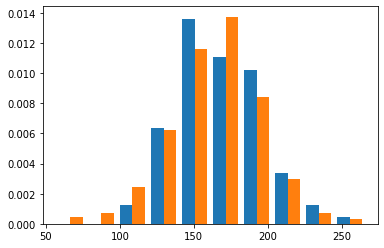

In [9]:
import matplotlib.pyplot as plt
plt.hist([evaluator.total_stat, actualstat.total_stat], density=True)

In [10]:
batsmen_result_dic = {}
bat_stat = evaluator.batsmen_stat
for batsman in bat_stat:
    tot_runs = 0
    tot_balls = 0
    num_4 = 0
    num_6 = 0
    num_inn = 0
    num_out = 0
    hs = 0
    dismissal_type = []
    dismissed_by = []
    for i in bat_stat[batsman]:
        num_inn += 1
        tot_runs += i["Runs"]
        if i["Runs"] > hs:
            hs = i["Runs"]
        tot_balls += i["Balls Faced"]
        num_4 += i["Fours"]
        num_6 += i["Sixes"]
        if i["Dismissal Type"] != "Not Out":
            num_out += 1
        dismissal_type.append(i["Dismissal Type"])
        dismissed_by.append(i["Dismissed By"])
    batsmen_result_dic[batsman] = {
        "Innings": num_inn,
        "Runs": tot_runs,
        "Balls": tot_balls,
        "Fours": num_4,
        "Sixes": num_6,
        "High Score": hs,
        "Average": tot_runs/num_out if num_out!=0 else tot_runs,
        "Strike Rate": tot_runs/tot_balls*100 if tot_balls!=0 else 0,
        "Boundry Percent": (6*num_6+4*num_4)/tot_runs*100 if tot_runs!=0 else 0,
        }

In [11]:
batsmen_stat_df = pd.DataFrame.from_dict(batsmen_result_dic, orient='index')
save_df = batsmen_stat_df.sort_values(by=["Runs", "Balls"], ascending=False)
# save_df.to_csv("Evaluation/Evaluate_Batsmen.csv")
save_df.head(20)

,Innings,Runs,Balls,Fours,Sixes,High Score,Average,Strike Rate,Boundry Percent
CA Lynn,28,1033,708,81,55,145,38.259259,145.903955,63.310745
P Shaw,28,1030,792,113,32,101,41.200000,130.050505,62.524272
J Bairstow,28,981,792,91,34,76,39.240000,123.863636,57.900102
PA Patel,28,931,644,116,28,88,37.240000,144.565217,67.883996
SK Raina,27,901,686,88,31,89,39.173913,131.341108,59.711432
RG Sharma,28,880,662,86,37,128,32.592593,132.930514,64.318182
Q de Kock,28,876,651,89,42,89,32.444444,134.562212,69.406393
MA Agarwal,28,852,638,82,31,83,35.500000,133.542320,60.328638
SA Yadav,28,831,532,97,33,100,36.130435,156.203008,70.517449
KL Rahul,28,821,591,87,35,132,31.576923,138.917090,67.965895


In [12]:
bowler_result_dic = {}
bowler_stat = evaluator.bowler_stat
for bowler in bowler_stat:
    tot_runs = 0
    tot_balls = 0
    tot_wickets = 0
    for i in bowler_stat[bowler]:
        tot_runs += i["Runs Conceded"]
        tot_balls += i["Balls"]
        tot_wickets += i["Wickets Taken"]
    bowler_result_dic[bowler] = {
        "Runs Conceded": tot_runs,
        "Overs": f"{tot_balls//6}.{tot_balls%6}",
        "Wickets": tot_wickets,
        "Economy": tot_runs/tot_balls*6 if tot_balls != 0 else 0,
        }


In [13]:
bowler_stat_df = pd.DataFrame.from_dict(bowler_result_dic, orient='index')
save_df = bowler_stat_df.sort_values(by=["Wickets", "Economy"], ascending=[False, True])
# save_df.to_csv("Evaluation/Evaluate_Bowler.csv")
save_df.head(20)

,Runs Conceded,Overs,Wickets,Economy
SP Narine,779,108.1,37,7.201849
Imran Tahir,870,111.0,35,7.837838
C de Grandhomme,969,109.0,35,8.889908
J Archer,837,93.4,34,8.935943
YS Chahal,902,112.0,33,8.053571
DJ Bravo,800,99.2,33,8.053691
A Mishra,843,109.0,32,7.733945
RA Jadeja,891,112.0,31,7.955357
L Ferguson,838,105.1,31,7.968304
JJ Bumrah,893,108.1,31,8.255778
